In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
from SED_CRNN import CRNN
from readers.featurizer import Wave2Mel

# import sys
# sys.path.append(r'C:/Program Files (zk)/PythonFiles/AClassification/SoundDL-CoughVID')
ROOT = "F:/DATAS/NEUCOUGHDATA_COUGHSINGLE/"

# Step 1 观察数据集

## 1.1 尝试根据时间截取片段

In [2]:
slice_raw = pd.read_csv(ROOT+'neucough_metainfo_slice.txt', header=0, index_col=None)
print(slice_raw)

             fileid       st        en  gender  issmoking  isalcohol  iscough  \
0    20240921104740  3:04.34  03:04.64       1          0          0        1   
1    20240921104740  3:04.62  03:04.88       1          0          0        1   
2    20240921104740  3:04.86  03:05.12       1          0          0        1   
3    20240921125652  3:01.50  03:01.93       0          0          0        0   
4    20240921125652  3:02.16  03:02.55       0          0          0        0   
..              ...      ...       ...     ...        ...        ...      ...   
316  20241008201738  3:36.63   3:37.03       1          0          0        0   
317  20241008201738  3:37.09   3:37.49       1          0          0        0   
318  20241008204801  3:30.95   3:31.16       0          0          0        0   
319  20241008204801  3:31.35   3:31.56       0          0          0        0   
320  20241008204801  3:31.69   3:31.87       0          0          0        0   

     isfever  isrespill  is

### 尝试一下标准化（绘图）

F:/DATAS/NEUCOUGHDATA_FULL/20240921104740_audiodata_元音字母a.wav
sample rate: 22050


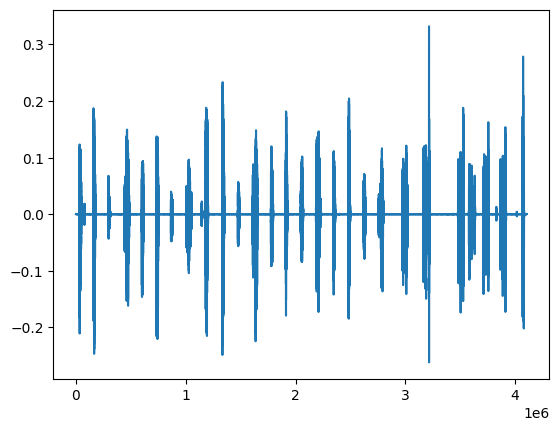

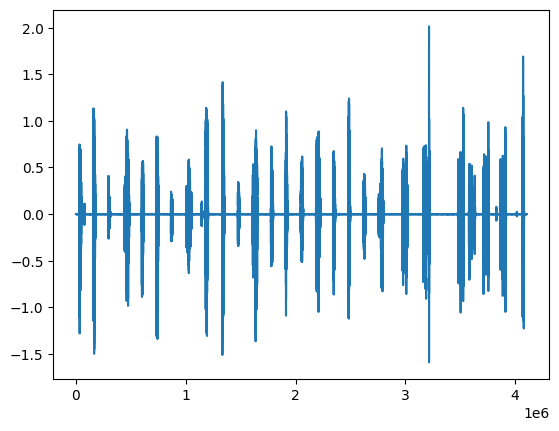

In [4]:
single_file = slice_raw.iloc[2, 0]
single_file_name = "F:/DATAS/NEUCOUGHDATA_FULL/{}_audiodata_元音字母a.wav".format(single_file)
print(single_file_name)
x, sr = librosa.load(single_file_name)
print("sample rate:", sr)

def rms_db(samples):
    """返回以分贝为单位的音频均方根能量

    :return: Root mean square energy in decibels.
    :rtype: float
    """
    # square root => multiply by 10 instead of 20 for dBs
    mean_square = np.mean(samples ** 2)
    return 10 * np.log10(mean_square)

def gain_db(sample, gain):
    return sample * 10.**(gain/20.)

def normalize(sample, target_db=-20, max_gain_db=300.0):
    if -np.inf == rms_db(sample):
        return
    gain = target_db - rms_db(sample)
    if gain > max_gain_db:
        raise ValueError(
            "无法将段规范化到 %f dB，因为可能的增益已经超过max_gain_db (%f dB)" % (target_db, max_gain_db))
    return gain_db(sample, min(max_gain_db, target_db - rms_db(sample)))

new_sample = normalize(x)
plt.figure(0)
plt.plot(x)
plt.figure(1)
plt.plot(new_sample)

# 根据标注的音频，读取srt然后根据区间判断是否静音，用时间窗作为单位
### 静音为01标注
### 读取ass字幕文件

## 读取单个文件的歌词和音频并切分出每个片段

In [3]:
def min2sec(t: str):
    parts = t.split(':')
    return int(parts[1]) * 60 + float(parts[2])

def read_ass_to_segs(asspath):
    fin = open(asspath, 'r', encoding="UTF-8")
    offset = 20
    while offset>0:
        fin.readline()
        offset -= 1
    intervals = []
    line = fin.readline()
    while line:
        parts = line.strip().split(',')
        # print(parts[1], parts[2], parts[-1])
        intervals.append((min2sec(parts[1]), min2sec(parts[2])))
        line = fin.readline()
    fin.close()
    return intervals

### 通过区间和IOU获取标注
- 截取段的起讫分别为st_pos, en_pos
- 判断段的起讫有三种，(st_pre, en_pre),(st_cur, en_cur),(st_tail, en_tail)
- 如果st_pos > st_cur 且 en_pos<en_cur， 则直接赋值为1 ([])
- 如果st_pos > st_cur 且 en_pos>en_cur，再判断en_pos和st_tail的大小 [(])
- 如果en_pos > st_cur 且 st_pos < st_cur， 再判断st_pos和en_pre的大小 ([)]

当st_cur, en_cur被扫过之后，更新每个的赋值

In [4]:
def read_audio_for_silence(wavname):
    intervals = read_ass_to_segs("F:/DATAS/NEUCOUGHDATA_FULL/{}_annotations.ass".format(wavname))
    print(intervals)
    sample, sr = librosa.load("F:/DATAS/NEUCOUGHDATA_FULL/{}_audiodata_元音字母a.wav".format(wavname))
    step, overlap = 8000, 2000
    st_pos, en_pos = 0, step
    st_pre, en_pre = -6001, -1
    Length = len(sample)
    st_cur, en_cur = int(intervals[0][0]*sr), int(intervals[0][1]*sr)
    st_tail, en_tail = int(intervals[1][0]*sr), int(intervals[1][1]*sr)
    jdx = 2
    Segs_List = []
    label_List = []
    tr = 0.3*(step+overlap)
    while en_cur < Length:
        if st_pos > st_cur:
            if en_pos < en_cur:
                label_List.append(1)  # ()([])()
            elif st_pos < en_cur:
                if en_cur - st_pos > tr:
                    label_List.append(1)  # ()([)]()
                else:
                    label_List.append(0)
            elif st_pos > en_cur:
                if en_pos > st_tail:
                    if en_pos - st_tail>tr:
                        label_List.append(1)  # ()()[(])
                    else:
                        label_List.append(0)
                else:
                    label_List.append(0)  # ()()[]()
        elif en_pos > st_cur:
            if en_pos - st_cur > tr:
                label_List.append(1)  # ()[(])()
            else:
                label_List.append(0)
        elif st_pos < en_pre:
            if en_pre - st_pos > tr:
                label_List.append(1)  # ([)]()()
            else:
                label_List.append(0)
        else:
            label_List.append(0)  # ()[]()()
        # print("st_pos:{}, en_pos:{},\nst_cur:{}, en_cur:{},\njdx:{}, interval:{},\nlen(label_List):{}, Length / step:{}, Length:{}".format(st_pos, en_pos, st_cur, en_cur, jdx, len(intervals), len(label_List), Length / step, Length))
        Segs_List.append(sample[st_pos:en_pos+overlap])
        if st_pos > en_cur:
            st_pre, en_pre = st_cur, en_cur
            st_cur, en_cur = st_tail, en_tail
            if jdx < len(intervals):
                st_tail, en_tail = int(intervals[jdx][0] * sr), int(intervals[jdx][1] * sr)
                jdx += 1
            else:
                st_tail, en_tail = Length + 1, Length + step
        st_pos, en_pos = en_pos, en_pos + step
    return Segs_List, label_List

Segs_List, label_List = read_audio_for_silence(wavname="20240921111118")
print(len(Segs_List),'\n', label_List)

[(2.48, 3.12), (8.91, 9.78), (14.87, 15.43), (22.48, 23.24), (23.28, 23.82), (23.82, 24.28), (30.87, 31.69), (35.51, 36.27), (40.55, 41.28), (47.17, 47.84), (47.81, 48.37), (48.4, 48.93), (55.94, 56.72), (62.29, 63.13), (68.27, 68.94), (74.53999999999999, 75.23), (75.25, 75.86), (75.88, 76.39), (82.74, 83.27), (88.16, 88.91), (94.05, 94.50999999999999), (100.38, 101.0), (100.96000000000001, 101.57), (101.59, 102.1), (106.97999999999999, 107.49000000000001), (114.97, 115.88), (120.89, 121.64), (127.37, 128.03), (127.99, 128.67), (128.68, 129.07), (137.55, 140.44), (148.43, 149.07999999999998), (149.16, 149.76), (149.76, 150.22), (150.32999999999998, 150.84), (155.88, 156.71), (156.68, 157.29), (157.51, 157.88), (158.16, 158.69), (162.27, 162.96), (162.99, 163.61), (163.71, 164.2), (164.45, 164.88), (170.04, 170.73), (170.74, 171.49), (171.53, 171.95), (172.17000000000002, 172.61), (176.89, 177.57999999999998), (177.77, 178.46), (178.42000000000002, 178.84), (179.15, 179.57), (185.28, 18

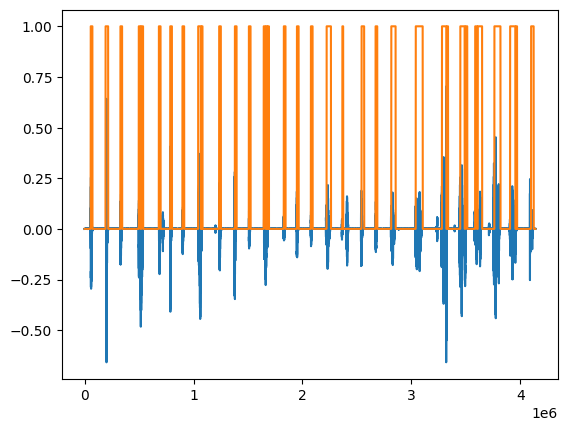

In [7]:
sample, sr = librosa.load("F:/DATAS/NEUCOUGHDATA_FULL/20240921111118_audiodata_元音字母a.wav")
new_List = []
repeat = len(sample) // len(label_List)
for item in label_List:
    for _ in range(repeat):
        new_List.append(item)
plt.figure(0)
plt.plot(sample)
plt.plot(new_List)
plt.savefig("C:/Program Files (zk)/PythonFiles/AClassification/SoundDL-CoughVID/SEDlabel.svg", dpi=600, format="svg", bbox_inches="tight")

In [25]:
class NEUCOUGHDataset(Dataset):
    def __init__(self, segs_list, label_list):
        self.segs_list = segs_list
        self.label_list = label_list
        
    def __getitem__(self, ind):
        return self.segs_list[ind], self.label_list[ind]

    def __len__(self):
        return len(self.label_list)

split_pos = int(len(label_List) * 0.9)

train_data, train_label = torch.from_numpy(np.array(Segs_List[:split_pos])), torch.from_numpy(np.array(label_List[:split_pos]))
valid_data, valid_label = torch.from_numpy(np.array(Segs_List[split_pos:])), torch.from_numpy(np.array(label_List[split_pos:]))
print("train_data:{}, train_label:{}, valid_data:{}, valid_label:{}".format(train_data.shape, train_label.shape, valid_data.shape, valid_label.shape))
train_dataset = NEUCOUGHDataset(train_data, train_label)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True,
                          pin_memory=True,
                          num_workers=0)
test_dataset = NEUCOUGHDataset(valid_data, valid_label)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False,
                         pin_memory=True,
                         num_workers=0)
print("Data Split into:", len(train_dataset), len(test_dataset))

train_data:torch.Size([464, 10000]), train_label:torch.Size([464]), valid_data:torch.Size([52, 10000]), valid_label:torch.Size([52])
Data Split into: 464 52


In [62]:
class TgramNet(nn.Module):
    def __init__(self, num_layer=3, mel_bins=128, win_len=1024, hop_len=512, num_class=2):
        super(TgramNet, self).__init__()
        # if "center=True" of stft, padding = win_len / 2
        self.conv_extrctor = nn.Conv1d(1, mel_bins, kernel_size=win_len, stride=hop_len, padding=win_len // 2, bias=False)
        
        self.conv_encoder = nn.Sequential()
        self.conv_encoder.append(nn.LayerNorm(20))
        self.conv_encoder.append(nn.LeakyReLU(0.2, inplace=True))
        self.conv_encoder.append(nn.Conv1d(mel_bins, mel_bins//2, kernel_size=3, stride=1, padding=1, bias=False))
        
        self.pooling = nn.Sequential()
        self.pooling.append(nn.MaxPool2d(4))
        self.pooling.append(nn.Flatten(start_dim=1))
        
        self.classifier = nn.Linear((mel_bins//2 * 20)//(4*4), num_class)

    def forward(self, x):
        out = self.conv_extrctor(x)
        # print("conv1d:", out.shape)
        out = self.conv_encoder(out)
        # print("encoder:", out.shape)
        out = self.pooling(out)
        # print("pooling:", out.shape)
        return self.classifier(out)

tgram = TgramNet(num_layer=2, num_class=2)
print(tgram)
input_wav = torch.rand(32, 1, 10000)
tgram(input_wav).shape

TgramNet(
  (conv_extrctor): Conv1d(1, 128, kernel_size=(1024,), stride=(512,), padding=(512,), bias=False)
  (conv_encoder): Sequential(
    (0): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  )
  (pooling): Sequential(
    (0): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=80, out_features=2, bias=True)
)


torch.Size([32, 2])

In [64]:
# params = {"pool_size": [8, 8, 2], "dropout_rate": 0.0, "batch_size": 32, "nb_cnn2d_filt": 64,
#               "rnn_size": [128, 128], "fnn_size": [256, 128, 32]}
device = torch.device("cuda")
model = TgramNet(num_layer=2, num_class=2).to(device)
print(model)
loss_f1 = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.004, betas=(0.5, 0.999))
Loss_List = []
for epoch_id in tqdm(range(20), desc=">>Epoch:"):
    # print()
    model.train()
    for idx, (x_input, y_label) in enumerate(train_loader):
        x_input = x_input.unsqueeze(1).to(device)
        y_label = y_label.to(device).to(torch.long)
        optimizer.zero_grad()
        y_pred = model(x_input)
        # print(y_pred.shape, y_label.shape)
        loss_v = loss_f1(input=y_pred, target=y_label)
        Loss_List.append(loss_v.item())
        loss_v.backward()
        optimizer.step()
    # print(Loss_List)

 
    model.eval()
    y_preds = None
    y_labels = None
    for idx, (x_input, y_label) in tqdm(enumerate(train_loader), desc=">>Valid Train:"):
        x_input = x_input.unsqueeze(1).to(device)
        y_label = y_label.to(device)
        if y_labels is None:
            y_labels = y_label
        else:
            y_labels = torch.concat((y_labels, y_label), dim=0)

        with torch.no_grad():
            y_pred = model(x_input)
        if y_preds is None:
            y_preds = y_pred
        else:
            y_preds = torch.concat((y_preds, y_pred), dim=0)
    from sklearn import metrics
    y_labs = y_labels.data.cpu().numpy()
    y_preds = y_preds.data.cpu().numpy()
    y_preds_label = y_preds.argmax(-1)
    precision = metrics.precision_score(y_labs, y_preds_label)
    recall = metrics.recall_score(y_labs, y_preds_label)
    acc = metrics.accuracy_score(y_labs, y_preds_label)
    print("\nTrain Dataset Result:", precision, recall, acc)

    y_preds = None
    y_labels = None
    for idx, (x_input, y_label) in tqdm(enumerate(test_loader), desc=">>Valid Test:"):
        x_input = x_input.unsqueeze(1).to(device)
        y_label = y_label.to(device)
        if y_labels is None:
            y_labels = y_label
        else:
            y_labels = torch.concat((y_labels, y_label), dim=0)

        with torch.no_grad():
            y_pred = model(x_input)
        if y_preds is None:
            y_preds = y_pred
        else:
            y_preds = torch.concat((y_preds, y_pred), dim=0)
    y_labs = y_labels.data.cpu().numpy()
    y_preds = y_preds.data.cpu().numpy()
    y_preds_label = y_preds.argmax(-1)
    precision = metrics.precision_score(y_labs, y_preds_label)
    recall = metrics.recall_score(y_labs, y_preds_label)
    acc = metrics.accuracy_score(y_labs, y_preds_label)
    print("Test Dataset Result:", precision, recall, acc)
    # if precision > 0.96 and recall > 0.96:
    #     save_dir = "./runs/sed_crnn/" + time.strftime("%Y%m%d%H%M", time.localtime()) + "/"
    #     if not os.path.exists(save_dir):
    #         os.makedirs(save_dir, exist_ok=True)
    #     torch.save(model.state_dict(), save_dir + "epoch_{}_sedmodel.pth".format(epoch_id))
    #     torch.save(optimizer.state_dict(), save_dir + "epoch_{}_optimizer.pth".format(epoch_id))


TgramNet(
  (conv_extrctor): Conv1d(1, 128, kernel_size=(1024,), stride=(512,), padding=(512,), bias=False)
  (conv_encoder): Sequential(
    (0): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  )
  (pooling): Sequential(
    (0): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=80, out_features=2, bias=True)
)


>>Epoch::   0%|                                                                                 | 0/20 [00:00<?, ?it/s]
>>Valid Train:: 29it [00:00, 337.21it/s]



Train Dataset Result: 0.875 0.7777777777777778 0.9418103448275862



>>Valid Test:: 4it [00:00, 363.65it/s]
>>Epoch::   5%|███▋                                                                     | 1/20 [00:00<00:05,  3.55it/s]

Test Dataset Result: 0.7692307692307693 0.5882352941176471 0.8076923076923077



>>Valid Train:: 29it [00:00, 1115.36it/s]



Train Dataset Result: 0.8709677419354839 1.0 0.9741379310344828



>>Valid Test:: 4it [00:00, 1000.07it/s]
>>Epoch::  10%|███████▎                                                                 | 2/20 [00:00<00:03,  5.39it/s]

Test Dataset Result: 0.7777777777777778 0.8235294117647058 0.8653846153846154



>>Valid Train:: 29it [00:00, 1160.03it/s]



Train Dataset Result: 1.0 0.8765432098765432 0.978448275862069



>>Valid Test:: 4it [00:00, 1333.64it/s]


Test Dataset Result: 0.9090909090909091 0.5882352941176471 0.8461538461538461



>>Valid Train:: 29it [00:00, 1114.87it/s]



Train Dataset Result: 1.0 0.9753086419753086 0.9956896551724138



>>Valid Test:: 4it [00:00, 1333.43it/s]
>>Epoch::  20%|██████████████▌                                                          | 4/20 [00:00<00:01,  8.17it/s]

Test Dataset Result: 1.0 0.6470588235294118 0.8846153846153846



>>Valid Train:: 29it [00:00, 1208.34it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 1000.01it/s]

Test Dataset Result: 0.875 0.8235294117647058 0.9038461538461539




>>Valid Train:: 29it [00:00, 1160.01it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 799.98it/s]
>>Epoch::  30%|█████████████████████▉                                                   | 6/20 [00:00<00:01,  9.38it/s]

Test Dataset Result: 0.875 0.8235294117647058 0.9038461538461539



>>Valid Train:: 29it [00:00, 1208.31it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 1333.32it/s]


Test Dataset Result: 0.875 0.8235294117647058 0.9038461538461539



>>Valid Train:: 29it [00:00, 1115.37it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 1000.07it/s]
>>Epoch::  40%|█████████████████████████████▏                                           | 8/20 [00:00<00:01, 10.15it/s]

Test Dataset Result: 0.875 0.8235294117647058 0.9038461538461539



>>Valid Train:: 29it [00:00, 1208.31it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 800.06it/s]


Test Dataset Result: 0.875 0.8235294117647058 0.9038461538461539



>>Valid Train:: 29it [00:00, 1208.34it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 799.98it/s]
>>Epoch::  50%|████████████████████████████████████                                    | 10/20 [00:01<00:00, 10.50it/s]

Test Dataset Result: 0.875 0.8235294117647058 0.9038461538461539



>>Valid Train:: 29it [00:00, 1208.34it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 1333.43it/s]


Test Dataset Result: 0.875 0.8235294117647058 0.9038461538461539



>>Valid Train:: 29it [00:00, 1208.32it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 1333.43it/s]
>>Epoch::  60%|███████████████████████████████████████████▏                            | 12/20 [00:01<00:00, 10.90it/s]

Test Dataset Result: 0.875 0.8235294117647058 0.9038461538461539



>>Valid Train:: 29it [00:00, 1035.60it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 999.95it/s]

Test Dataset Result: 0.875 0.8235294117647058 0.9038461538461539




>>Valid Train:: 29it [00:00, 1168.99it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 799.98it/s]
>>Epoch::  70%|██████████████████████████████████████████████████▍                     | 14/20 [00:01<00:00, 10.79it/s]

Test Dataset Result: 0.875 0.8235294117647058 0.9038461538461539



>>Valid Train:: 29it [00:00, 1260.88it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 1333.32it/s]


Test Dataset Result: 0.875 0.8235294117647058 0.9038461538461539



>>Valid Train:: 29it [00:00, 1208.34it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 1333.43it/s]
>>Epoch::  80%|█████████████████████████████████████████████████████████▌              | 16/20 [00:01<00:00, 11.27it/s]

Test Dataset Result: 0.875 0.8235294117647058 0.9038461538461539



>>Valid Train:: 29it [00:00, 1260.87it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 1333.32it/s]


Test Dataset Result: 0.9333333333333333 0.8235294117647058 0.9230769230769231



>>Valid Train:: 29it [00:00, 1260.87it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 1333.11it/s]
>>Epoch::  90%|████████████████████████████████████████████████████████████████▊       | 18/20 [00:01<00:00, 11.15it/s]

Test Dataset Result: 0.9333333333333333 0.8235294117647058 0.9230769230769231



>>Valid Train:: 29it [00:00, 1318.19it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 1333.54it/s]


Test Dataset Result: 0.9333333333333333 0.8235294117647058 0.9230769230769231



>>Valid Train:: 29it [00:00, 1260.88it/s]



Train Dataset Result: 1.0 1.0 1.0



>>Valid Test:: 4it [00:00, 1000.07it/s]
>>Epoch:: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.22it/s]

Test Dataset Result: 0.9333333333333333 0.8235294117647058 0.9230769230769231


# End